In [1]:
import sys
sys.executable

'/usr/bin/python'

In [2]:
"""
    Predicting Bitcoin pice using 2-layers long short term memory (LSTM),
    as well as Gated Recurrent Unit (GRU) architecture of the Recurrent 
    Neural Network. 
    Refs: 
      -  https://deeplearning4j.org/lstm.html
      -  http://colah.github.io/posts/2015-08-Understanding-LSTMs/
      -  https://arxiv.org/pdf/1412.3555v1.pdf
      -  http://karpathy.github.io/2015/05/21/rnn-effectiveness/
"""

import warnings
warnings.filterwarnings("ignore")

from cryptory import Cryptory
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
import matplotlib.pyplot as plt
from datetime import datetime
import time
import datetime
import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [3]:
data = pd.read_csv("../datasets/bitcoin-historical-data-kaggle/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv")
data.isnull().values.any()

False

In [4]:
from_date="2013-04-30"
to_date="2018-09-10" #datetime.today().strftime("%Y-%m-%d")
my_cryptory = Cryptory(from_date, to_date)

In [5]:
coinmarket_btc_market_info = my_cryptory.extract_coinmarketcap("bitcoin")
# coinmarket_btc_market_info.set_index('date')

In [6]:
x = coinmarket_btc_market_info['date']
y = coinmarket_btc_market_info['close']

# k = data['Timestamp']
# z = data['']

layout = go.Layout(
    title="Bitcoin Coinmarketcap",
    yaxis=dict(
        title='Cmimi'
    ),
    xaxis=dict(
        title='Koha'
    )
)

trace1 = go.Scatter(
    x=x,
    y=y,
    mode='lines',
    name='Bitcoin Price',
    line=dict(
        shape='spline'
    )
)

fig = go.Figure(data=[trace1], layout=layout)
py.offline.iplot(fig)

### Transfer the data to get the average price grouped by the day and to see usual datetime format, not timestamped as above

In [7]:
data = coinmarket_btc_market_info
# data['date'] = pd.to_datetime(data['date'],unit='d').dt.date
# group = data.groupby('date')
# print(group)
# Daily_Price = group['close'].mean()
Daily_Price = data[['date','close']].copy()
Daily_Price['date'] = pd.to_datetime(Daily_Price['date'])
Daily_Price = Daily_Price.set_index('date')
# Daily_Price.index = Daily_Price.index.to_datetime()

# Daily_Price.resample('5min', how='mean')
print(type(Daily_Price))
print(Daily_Price.head())
# Daily_Price.drop(axis=0, index=None)
# Daily_Price.set_index('date')

<class 'pandas.core.frame.DataFrame'>
              close
date               
2018-09-10  6329.70
2018-09-09  6300.86
2018-09-08  6225.98
2018-09-07  6467.07
2018-09-06  6529.17


In [8]:
Daily_Price.tail()

,close
date,
2013-05-04,112.50
2013-05-03,97.75
2013-05-02,105.21
2013-05-01,116.99
2013-04-30,139.00


In [9]:
from calendar import monthrange
from datetime import datetime, timedelta

def monthdelta(d1, d2):
    delta = 0
    while True:
        mdays = monthrange(d1.year, d1.month)[1]
        d1 += timedelta(days=mdays)
        if d1 <= d2:
            delta += 1
        else:
            break
    return delta

In [10]:
from datetime import date

# d0 = date(2016, 1, 1)
# d1 = date(2017, 10, 15)

d0 = date(2017, 1, 1)
d1 = date(2018, 9, 5)
delta = d1 - d0
days_look = delta.days + 1
print("Months in total(train+test): " + str(monthdelta(d0,d1)))
print("Days in total(train+test): "+ str( (d1-d0).days))
print(days_look)

# d0 = date(2017, 8, 21)
# d1 = date(2017, 10, 20)
d0 = date(2018, 7, 21)
d1 = date(2018, 9, 10)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2018, 9, 5)
d1 = date(2018, 9, 10)
delta = d1 - d0
days_from_end = delta.days + 1

Months in total(train+test): 20
Days in total(train+test): 612
613
52


In [11]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

(567, 52)


### Exploratory Analysis

In [12]:
# working_data = [df_train, df_test]
# working_data = pd.concat(working_data)

# working_data = working_data.reset_index()
# working_data['date'] = pd.to_datetime(working_data['date'])
# # working_data = working_data.set_index('date')
# working_data.reset_index(drop = True, inplace = True)
# print(working_data)
# a = working

working_data = [df_train, df_test]
working_data = pd.concat(working_data)

# working_data = working_data.reset_index()
# working_data['date'] = pd.to_datetime(working_data['date'])
# working_data = working_data.set_index('date')

In [13]:
# 60 -> days_from_end; 
s = sm.tsa.seasonal_decompose(working_data.close.values, freq=51)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

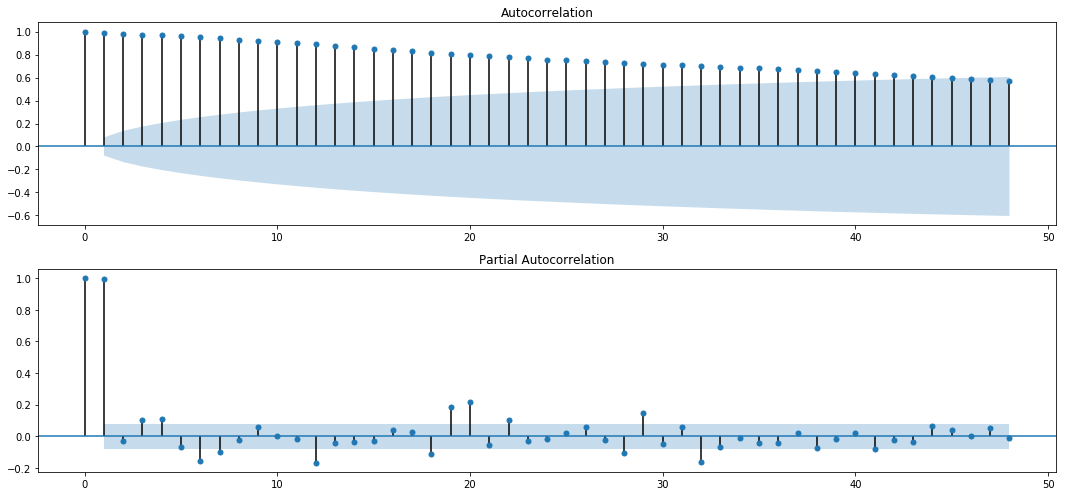

In [14]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.close.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.close.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [15]:
df_train = working_data[:-51]
df_test = working_data[-51:]

#### Data preparation
We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of this values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1).

In [21]:
def create_lookback(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a) # Because we have only one feature
#         Y.append(dataset[i + look_back, 0])
    Y = np.squeeze(np.asarray(dataset[1:,:]))
    return np.array(X), np.array(Y)


df_train.index.name = None
df_train = df_train.rename_axis(None)
df_test = df_test.rename_axis(None)

# df.reset_index(inplace=True) # Resets the index, makes factor a column
# df.drop("Factor",axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
df_train.reset_index(drop=True, inplace=True)
print(training_set[0:5])

[[0.19849641]
 [0.20864658]
 [0.20111938]
 [0.19029499]
 [0.1808098 ]]


In [23]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

print(Y_train)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

[0.20864658 0.20111938 0.19029499 0.1808098  0.19639987 0.22775551
 0.22703511 0.2325212  0.22379334 0.22557585 0.22979663 0.22852208
 0.23966049 0.23143137 0.23468238 0.24580232 0.24332711 0.23312153
 0.2415446  0.23035078 0.2244029  0.23214253 0.23886621 0.25575854
 0.26155864 0.25763341 0.2623991  0.26052423 0.25669136 0.26210355
 0.27105307 0.28323513 0.28294882 0.2848514  0.27815542 0.283152
 0.28897981 0.28705876 0.28595969 0.28359532 0.28448196 0.27822007
 0.27701941 0.28346602 0.28489757 0.27628055 0.26275006 0.26083824
 0.26729409 0.28826865 0.28332748 0.29460443 0.29503851 0.28418642
 0.30421893 0.32537821 0.32799195 0.27640061 0.27568022 0.27229991
 0.25588784 0.25305244 0.25939745 0.25034634 0.2420341  0.23931877
 0.23778562 0.23765632 0.24926575 0.25571236 0.24674437 0.2670909
 0.26281471 0.26439404 0.25753182 0.26776511 0.26782977 0.2906792
 0.2937455  0.29039289 0.2965809  0.29832647 0.29123335 0.29012505
 0.301402   0.30703585 0.29737518 0.28642149 0.27141327 0.27072982

In [28]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


Train on 567 samples, validate on 50 samples
Epoch 1/100
567/567 [==============================] - 2s 3ms/step - loss: 0.0628 - val_loss: 0.0517
Epoch 2/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0225 - val_loss: 0.0296
Epoch 3/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 4/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 3.9419e-05
Epoch 5/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 2.3807e-05
Epoch 6/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 4.3412e-05
Epoch 7/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0017 - val_loss: 4.9906e-05
Epoch 8/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 5.0842e-05
Epoch 9/100
567/567 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 4.4093e-05
Epoch 10/100
567/567 [

In [29]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [42]:
# add one additional data point to align shapes of the predictions and true labels
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [43]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted labels',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [44]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

ValueError: Found input variables with inconsistent numbers of samples: [50, 53]

In [38]:
Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

In [39]:
# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1):
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0]))
    X_test = np.reshape(X_test, (len(X_test), 1, 1))

    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [40]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [46]:
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 568,n_test = 51)
print('Test GRU model RMSE: %.3f' % RMSE)

1960
1960
Test GRU model RMSE: 4.130


In [47]:
# This function is used to repeat the workflow ten times and to calculate average RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

In [48]:
mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

('Iteration:', 1)
1960
1960
Test RMSE: 1.984
('Iteration:', 2)
1960
1960
Test RMSE: 1.712
('Iteration:', 3)
1960
1960
Test RMSE: 2.078
('Iteration:', 4)
1960
1960
Test RMSE: 3.099
('Iteration:', 5)
1960
1960
Test RMSE: 0.554
('Iteration:', 6)
1960
1960
Test RMSE: 1.962
('Iteration:', 7)
1960
1960
Test RMSE: 0.583
('Iteration:', 8)
1960
1960
Test RMSE: 13.397
('Iteration:', 9)
1960
1960
Test RMSE: 2.322
('Iteration:', 10)
1960
1960
Test RMSE: 0.416
('Average RMSE: ', 2.810710325099398)
('RMSE list:', [1.9835622889882079, 1.7116269736331666, 2.0783551978840453, 3.0988445756969885, 0.5539842393807707, 1.9621806560814983, 0.5833701552737978, 13.396508325167153, 2.3223700276350137, 0.4163008112533408])


In [226]:
predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 4.611


In [227]:
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

In [228]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

# We can see that our SMAPE is less than 1%, which means that the error of our model is very small.
print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 3.950


In [27]:
dat = np.array([[0, 0, 0, 0, 9],
                [1, 1, 1, 1, 9],
                [2, 2, 2, 2, 9],
                [3, 3, 3, 3, 9],
                [4, 4, 4, 4, 9],
                [5, 5, 5, 5, 9],
                [6, 6, 6, 6, 9],
                [7, 7, 7, 7, 9],
                [8, 8, 8, 8, 9]], np.int32)

In [28]:
print(dat)

[[0 0 0 0 9]
 [1 1 1 1 9]
 [2 2 2 2 9]
 [3 3 3 3 9]
 [4 4 4 4 9]
 [5 5 5 5 9]
 [6 6 6 6 9]
 [7 7 7 7 9]
 [8 8 8 8 9]]


In [29]:
X = dat[:,:-1].copy()
Y = dat[:,-1:].copy()

In [30]:
X

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4],
       [5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [8, 8, 8, 8]], dtype=int32)

In [31]:
Y

array([[9],
       [9],
       [9],
       [9],
       [9],
       [9],
       [9],
       [9],
       [9]], dtype=int32)

In [32]:
# set the number of timesteps
timesteps = 4

In [33]:
# reshape input to be: (samples, time steps, features)
X = reshape_data(X, timesteps)
Y = reshape_data(Y, timesteps)

NameError: name 'reshape_data' is not defined